## Test with sliding window of 30 minutes with 1 minute overlap

### This is the best result we have so far, so we need to explore why this is happening

Despike filter = 50 (signal 50x the mean is removed)

In [60]:
import pandas as pd
import obspy as op
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import glob
%matplotlib inline

In [61]:
all_data = pd.read_csv("Fnames_soilM_temp.csv")
lineCSN = all_data[all_data['Line'] == "LineCSN"]

#Extract just the soil moisture time series corresponding to probe M3_20
lineCSN_M3 = lineCSN[['file_name','DateTime','M3_20_Avg_interp','Temphigh_interp']]
lineCSN_M3.reset_index(drop=True,inplace=True)
lineCSN_M3.assign(DateTime = pd.to_datetime(lineCSN_M3['DateTime']))
lineCSN_M3.set_index('DateTime',inplace=True)
#Generate linking column
lineCSN_M3 = lineCSN_M3.assign(file_name=lineCSN_M3['file_name'].apply(lambda x: x[2:]))

In [244]:
feature_files = glob.glob('/home/rmartinshort/Documents/Berkeley/Fiber/data_test/Soil_moisture_predict/rms_sliding_30_1/*.csv')
feature_dfs = []
for csv_file in feature_files:
    fname = csv_file.split('/')[-1].split('.')[0][:-19]
    print(fname)
    df = pd.read_csv(csv_file)
    df.name = fname
    feature_dfs.append(df)

mean_change_rms
kurtosis_rms
abs_energy_rms
variance_rms
mean_rms
maximum_rms
minimum_rms
cid_ce_rms
median_rms
mean_abs_change_rms
root_mean_square_rms
fft_energy_rms
peak_welch_rms
skewness_rms
interquartile_range_rms
x_crossing_m_rms


In [63]:
lineCSN_M3['TTime'] = lineCSN_M3.index
stime = lineCSN_M3.index[0]
print(op.UTCDateTime(stime))
lineCSN_M3 = lineCSN_M3.assign(tsince_start=lineCSN_M3['TTime'].apply(lambda x: op.UTCDateTime(x) - op.UTCDateTime(stime)))

2016-08-05T18:07:38.000000Z


In [64]:
f_soilM = interpolate.interp1d(lineCSN_M3['tsince_start'].values,lineCSN_M3['M3_20_Avg_interp'].values)
f_temp = interpolate.interp1d(lineCSN_M3['tsince_start'].values,lineCSN_M3['Temphigh_interp'].values)

In [130]:
def extract_mean_over_channels(indf,channels_to_drop):
    
    '''Takes an input dataframe, calculates the mean over columns that are not in the list 
    "channels_to_drop". Returns mean dataframe
    '''
    
    newcolname = "mean_%s" %indf.name
    opdf = indf[['time']]
    
    ### This requires all data to be non NAN in that window, otherwise a NAN is reported
    opdf = opdf.assign(mean_col = indf.drop(channels_to_drop,axis=1).mean(axis=1,skipna=False))
    opdf.columns = ['time',newcolname]
    
    return opdf

In [131]:
feature_dfs[0].head()

,channel_80,channel_81,channel_82,channel_83,channel_84,channel_85,channel_86,channel_87,channel_88,channel_89,time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T18:53:01.281914Z
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T18:54:01.282279Z
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T18:55:01.282279Z
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T18:56:01.282279Z
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T18:57:01.282279Z


# Test 1 

### Extract just the channels around the probe - 84,85 and 86. Determine their mean features and predict off those

In [284]:
channels_to_drop = ['time','channel_80','channel_81','channel_82','channel_83',
                    'channel_87','channel_88','channel_89']

#channels_to_drop = ['time']

print(len(feature_dfs[0]))
indf = extract_mean_over_channels(feature_dfs[0],channels_to_drop)


64649


In [285]:
len(indf)

64649

In [286]:

for feature_df in feature_dfs[1:]:
    
    mean_feature = extract_mean_over_channels(feature_df,channels_to_drop)
    merged_df = pd.merge(indf,mean_feature,on='time')
    indf = merged_df
    print(len(indf))

64649
64649
64649
64649
64649
64649
64649
64649
64649
64649
64649
64649
64649
64649
64649


In [287]:
merged_df.head()

,time,mean_mean_change_rms,mean_kurtosis_rms,mean_abs_energy_rms,mean_variance_rms,mean_mean_rms,mean_maximum_rms,mean_minimum_rms,mean_cid_ce_rms,mean_median_rms,mean_mean_abs_change_rms,mean_root_mean_square_rms,mean_fft_energy_rms,mean_peak_welch_rms,mean_skewness_rms,mean_interquartile_range_rms,mean_x_crossing_m_rms
0,2016-08-05T18:53:01.281914Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-08-05T18:54:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-08-05T18:55:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-08-05T18:56:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-08-05T18:57:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [288]:
merged_df = merged_df.assign(tsince_start=merged_df['time'].apply(lambda x: op.UTCDateTime(x)-op.UTCDateTime(stime)))  
merged_df = merged_df.assign(M3_20_Avg_interp=merged_df['tsince_start'].apply(lambda x: f_soilM(x)))
merged_df = merged_df.assign(Temphigh_interp=merged_df['tsince_start'].apply(lambda x: f_temp(x)))

In [289]:
print(len(merged_df))
cleaned_df = merged_df.dropna()
len(cleaned_df)

64649


9073

In [290]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [291]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,min_samples_split=2,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

min_samples_leaf = 1 produces the best results here. Varying the number of trees between 200 and 800 has little effect

In [292]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.00674676 0.08056402 0.01655096 0.01715687 0.12480817 0.08529681
 0.07952078 0.04498742 0.13022642 0.02989545 0.02525637 0.01488952
 0.06596169 0.06248518 0.05241891 0.16323467]
0.8807195172612114


In [293]:
regr.score(X_test,y_test)

0.8844333883716812

In [294]:
regr_pred = regr.predict(X_test)

outliers_y = []
outliers_x = []
X_test_indices_bad = []
X_test_indices_good = []
i = 0
for element in zip(regr_pred,y_test):
    if abs(element[0]-element[1]) > 0.015:
        outliers_x.append(element[0])
        outliers_y.append(element[1])
        X_test_indices_bad.append(X_test.index[i])
    else:
        X_test_indices_good.append(X_test.index[i])
    i += 1

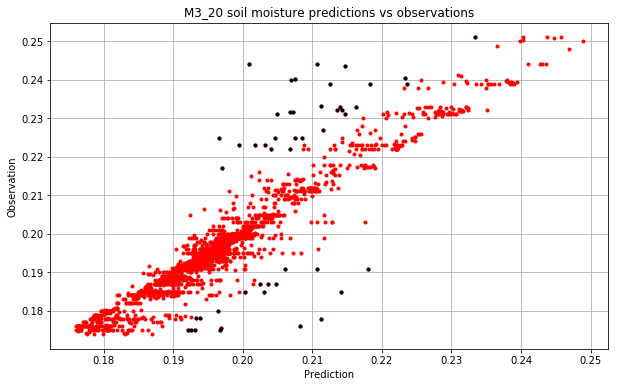

In [295]:
plt.figure(figsize=(10,6))
plt.title('M3_20 soil moisture predictions vs observations')
plt.plot(regr_pred,y_test,'r.')
plt.plot(outliers_x,outliers_y,'k.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_moisture_prediction_sliding_window.png')

In [296]:
outliers = cleaned_df.loc[X_test_indices_bad]
inliers = cleaned_df.loc[X_test_indices_good]
outlier_x = np.array(outliers['tsince_start'])
outlier_y = np.array(outliers['M3_20_Avg_interp'])
inlier_x = np.array(inliers['tsince_start'])
inlier_y = np.array(inliers['M3_20_Avg_interp'])
reg_x = np.array(cleaned_df['tsince_start'])
reg_y = np.array(cleaned_df['M3_20_Avg_interp'])

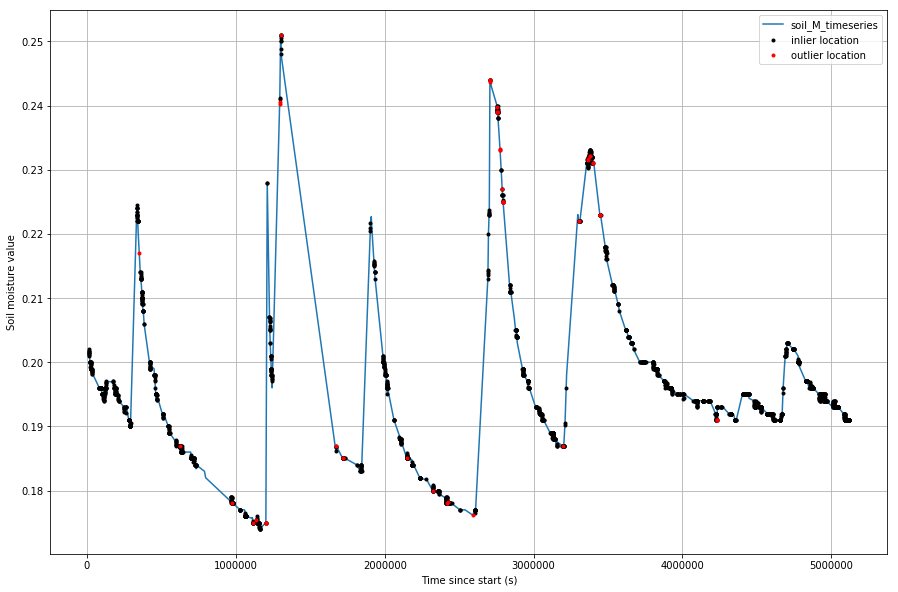

In [297]:
plt.figure(figsize=(15,10))
plt.plot(reg_x,reg_y,label='soil_M_timeseries')
plt.plot(inlier_x,inlier_y,'k.',label='inlier location')
plt.plot(outlier_x,outlier_y,'r.',label='outlier location')
plt.xlabel('Time since start (s)')
plt.ylabel('Soil moisture value')
plt.legend()
plt.grid()

In [298]:
inds = np.argsort(regr.feature_importances_)[::-1]

for i in range(10):
    print(regr.feature_importances_[inds[i]],X.columns[inds[i]])

0.163234673082097 mean_x_crossing_m_rms
0.13022641571749063 mean_median_rms
0.12480816978399531 mean_mean_rms
0.08529681348636292 mean_maximum_rms
0.0805640162275533 mean_kurtosis_rms
0.0795207779149587 mean_minimum_rms
0.06596168974484352 mean_peak_welch_rms
0.06248517625717818 mean_skewness_rms
0.05241891217813698 mean_interquartile_range_rms
0.04498742375479518 mean_cid_ce_rms


Again, the peaks and troughs are not well predicted, but the rest of the timseries is. We should try to see if this model yeilds decent results when applied to features calculated close to another soil moisture probe.

We can also see that there are large tim windows inwhich values on one or more channels are NA.

This result is quite promising though - suggests that 30 minute windows with 1 minute overlap is a good place to start. The despike filter of 50 may also be playing an importnat role here, so we need to look into that in more detail

## What about the temperature data?

In [299]:
y = cleaned_df['Temphigh_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,min_samples_split=2,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [300]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.00483764 0.04388163 0.01456332 0.01166174 0.10341495 0.07999347
 0.07900935 0.02734766 0.08036    0.03152787 0.01436041 0.01173093
 0.14179528 0.03883696 0.05301781 0.26366098]
0.9140374131247182


In [301]:
regr_pred = regr.predict(X_test)
outliers_y = []
outliers_x = []
X_test_indices = []
i = 0
for element in zip(regr_pred,y_test):
    if abs(element[0]-element[1]) > 4:
        outliers_x.append(element[0])
        outliers_y.append(element[1])
        X_test_indices.append(X_test.index[i])
    i += 1

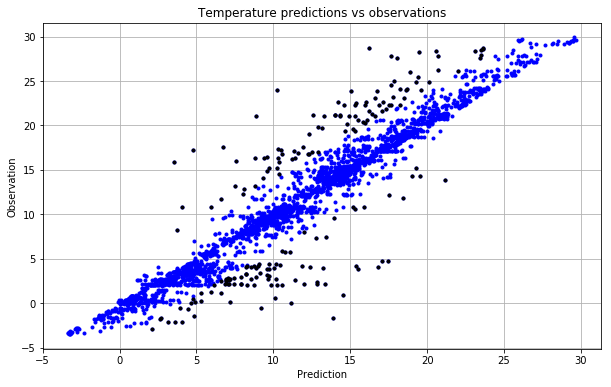

In [302]:
plt.figure(figsize=(10,6))
plt.title('Temperature predictions vs observations')
plt.plot(regr_pred,y_test,'b.')
plt.plot(outliers_x,outliers_y,'k.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('temperature_prediction_sliding_window.png')

Again, this is very well predicted. We need to understand why this is so much better than previous cases

# Test 2 

## Just extracting features at channel 85

In [213]:
channels_to_drop = ['time','channel_80','channel_81','channel_82','channel_83','channel_84','channel_86',
                    'channel_87','channel_88','channel_89']
indf = extract_mean_over_channels(feature_dfs[0],channels_to_drop)

for feature_df in feature_dfs[1:]:
    
    mean_feature = extract_mean_over_channels(feature_df,channels_to_drop)
    merged_df = pd.merge(indf,mean_feature,on='time')
    indf = merged_df
    print(len(indf))

64649
64649
64649
64649
64649
64649
64649
64649
64649
64649
64649
64649
64649
64649
64649


In [214]:
merged_df = merged_df.assign(tsince_start=merged_df['time'].apply(lambda x: op.UTCDateTime(x)-op.UTCDateTime(stime)))  
merged_df = merged_df.assign(M3_20_Avg_interp=merged_df['tsince_start'].apply(lambda x: f_soilM(x)))
merged_df = merged_df.assign(Temphigh_interp=merged_df['tsince_start'].apply(lambda x: f_temp(x)))

In [215]:
print(len(merged_df))
cleaned_df = merged_df.dropna()
len(cleaned_df)

64649


11207

In [216]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [217]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=500,min_samples_leaf=1,min_samples_split=2,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [218]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.00717145 0.06320637 0.01352507 0.01372207 0.11901746 0.11488
 0.11868895 0.04326473 0.09634612 0.0375254  0.01327864 0.01347392
 0.09264411 0.06214963 0.04244637 0.14865971]
0.8837614158585876


In [219]:
regr.score(X_test,y_test)

0.8894486383276381

In [220]:
regr_pred = regr.predict(X_test)

outliers_y = []
outliers_x = []
X_test_indices_bad = []
X_test_indices_good = []
i = 0
for element in zip(regr_pred,y_test):
    if abs(element[0]-element[1]) > 0.015:
        outliers_x.append(element[0])
        outliers_y.append(element[1])
        X_test_indices_bad.append(X_test.index[i])
    else:
        X_test_indices_good.append(X_test.index[i])
    i += 1

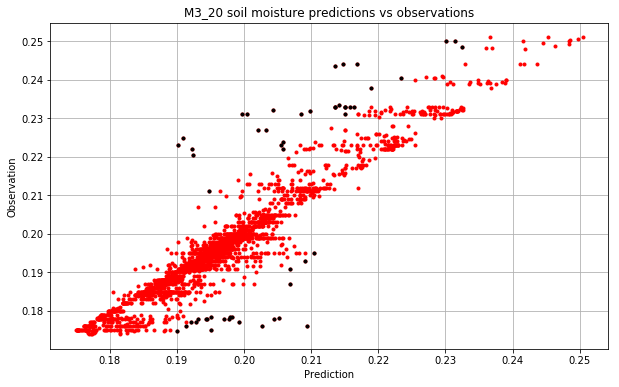

In [222]:
plt.figure(figsize=(10,6))
plt.title('M3_20 soil moisture predictions vs observations')
plt.plot(regr_pred,y_test,'r.')
plt.plot(outliers_x,outliers_y,'k.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_moisture_prediction_sliding_window.png')

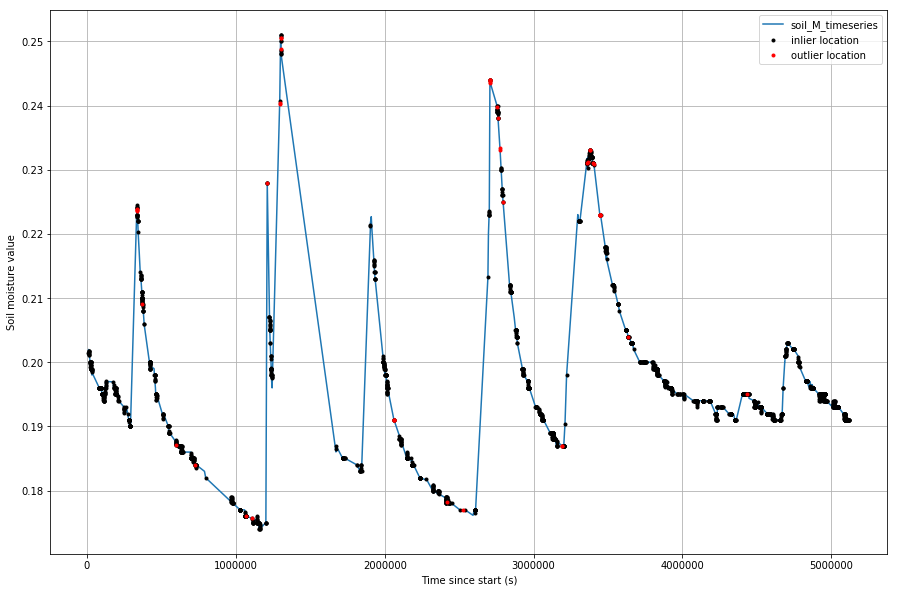

In [221]:
plt.figure(figsize=(15,10))
plt.plot(reg_x,reg_y,label='soil_M_timeseries')
plt.plot(inlier_x,inlier_y,'k.',label='inlier location')
plt.plot(outlier_x,outlier_y,'r.',label='outlier location')
plt.xlabel('Time since start (s)')
plt.ylabel('Soil moisture value')
plt.legend()
plt.grid()

In [223]:
inds = np.argsort(regr.feature_importances_)[::-1]

for i in range(10):
    print(regr.feature_importances_[inds[i]],X.columns[inds[i]])

0.1486597086992985 mean_x_crossing_m_rms
0.1190174570555897 mean_mean_rms
0.11868894757651169 mean_minimum_rms
0.11488000192613602 mean_maximum_rms
0.09634611627420185 mean_median_rms
0.09264410713699686 mean_peak_welch_rms
0.06320637449707597 mean_kurtosis_rms
0.062149632393657346 mean_skewness_rms
0.04326472963089188 mean_cid_ce_rms
0.042446367786689275 mean_interquartile_range_rms


Very similar result to using the mean of the three channels

In [158]:
len(regr_pred)

3363

# Test 3 

## Use channel-specific features 

In [260]:
def extract_specific_channels(indf,channels_to_drop=None):
    
    newchannames = []
    if channels_to_drop:
        opdf = indf.drop(channels_to_drop,axis=1)
    else:
        opdf = indf.copy()
    for name in opdf.columns:
        new_name = "%s_%s" %(name,indf.name)
        newchannames.append(new_name)
        
    newchannames[-1] = "time"
    opdf.columns = newchannames
    
    return opdf

In [261]:
feature_dfs[0].head()

,channel_80,channel_81,channel_82,channel_83,channel_84,channel_85,channel_86,channel_87,channel_88,channel_89,time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T18:53:01.281914Z
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T18:54:01.282279Z
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T18:55:01.282279Z
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T18:56:01.282279Z
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T18:57:01.282279Z


In [262]:
channels_to_drop = ['channel_80','channel_81','channel_82','channel_83',
                    'channel_87','channel_88','channel_89']
channels_to_drop = None

odf = extract_specific_channels(feature_dfs[0],channels_to_drop)

In [263]:
for feature_df in feature_dfs[1:]:
       
    selected_features_df = extract_specific_channels(feature_df,channels_to_drop)
    merged_df = pd.merge(odf,selected_features_df,on='time')
    odf = merged_df

In [264]:
merged_df.head()

,channel_80_mean_change_rms,channel_81_mean_change_rms,channel_82_mean_change_rms,channel_83_mean_change_rms,channel_84_mean_change_rms,channel_85_mean_change_rms,channel_86_mean_change_rms,channel_87_mean_change_rms,channel_88_mean_change_rms,channel_89_mean_change_rms,...,channel_80_x_crossing_m_rms,channel_81_x_crossing_m_rms,channel_82_x_crossing_m_rms,channel_83_x_crossing_m_rms,channel_84_x_crossing_m_rms,channel_85_x_crossing_m_rms,channel_86_x_crossing_m_rms,channel_87_x_crossing_m_rms,channel_88_x_crossing_m_rms,channel_89_x_crossing_m_rms
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [265]:
merged_df = merged_df.assign(tsince_start=merged_df['time'].apply(lambda x: op.UTCDateTime(x)-op.UTCDateTime(stime)))
merged_df = merged_df.assign(M3_20_Avg_interp=merged_df['tsince_start'].apply(lambda x: f_soilM(x)))
merged_df = merged_df.assign(Temphigh_interp=merged_df['tsince_start'].apply(lambda x: f_temp(x)))
print(len(merged_df))
cleaned_df = merged_df.dropna()
print(len(cleaned_df)) #This should be equal to the number of data points in the 'mean across channels' experiment

64649
6195


In [275]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=800,min_samples_leaf=1,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [276]:
regr.oob_score_

0.9144426022059774

In [277]:
inds = np.argsort(regr.feature_importances_)[::-1]

for i in range(10):
    print(regr.feature_importances_[inds[i]],X.columns[inds[i]])

0.04850093997746094 channel_82_peak_welch_rms
0.03778649070435955 channel_85_x_crossing_m_rms
0.03223950530897072 channel_88_mean_rms
0.031499573117622325 channel_84_skewness_rms
0.024812289757360245 channel_82_median_rms
0.024793330576032425 channel_80_minimum_rms
0.02169572843450377 channel_87_peak_welch_rms
0.021389062238417002 channel_89_x_crossing_m_rms
0.020697773403278722 channel_88_peak_welch_rms
0.020287175500774416 channel_82_maximum_rms


In [272]:
regr.score(X_test,y_test)

0.9291006659199604

In [273]:
regr_pred = regr.predict(X_test)

outliers_y = []
outliers_x = []
X_test_indices_bad = []
X_test_indices_good = []
i = 0
for element in zip(regr_pred,y_test):
    if abs(element[0]-element[1]) > 0.015:
        outliers_x.append(element[0])
        outliers_y.append(element[1])
        X_test_indices_bad.append(X_test.index[i])
    else:
        X_test_indices_good.append(X_test.index[i])
    i += 1

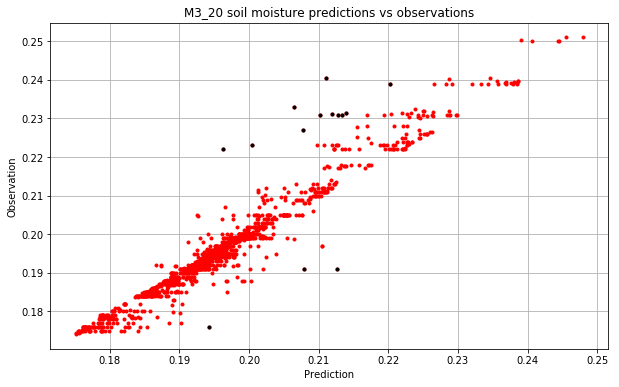

In [274]:
plt.figure(figsize=(10,6))
plt.title('M3_20 soil moisture predictions vs observations')
plt.plot(regr_pred,y_test,'r.')
plt.plot(outliers_x,outliers_y,'k.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_moisture_prediction_sliding_window.png')

If channels_to_drop = None,the fit is excellent. Note that the number of points is quite small though, corresponding to just 30 minute time windows where the DAS data had no NaN valued samples